<a href="https://colab.research.google.com/github/WellFan/bayesian_with_baseball/blob/main/baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are studying on Lahman dataset, which contains baseball game datas from MLB.  
We will be  
1. Using bayesion technique to compute the hitting rate  
2. Adding hierarchical model
3. Using Stan package

to help us understand what bayesian does.

In [64]:
import pandas as pd
import numpy as np

In [65]:
batting = pd.read_csv("https://raw.githubusercontent.com/WellFan/bayesian_with_baseball/main/baseballdatabank-2022.2/core/Batting.csv")
pitching = pd.read_csv("https://raw.githubusercontent.com/WellFan/bayesian_with_baseball/main/baseballdatabank-2022.2/core/Pitching.csv")

In [66]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


Generating 

\[H]: hit

[AB]: at bat

[AVG]: batting average

In [25]:
career = batting[batting.AB > 0]
career = pd.merge(career, pitching, how='outer', on='playerID', indicator=True)
career = (career[~(career._merge == 'both')]
          .drop('_merge', axis=1).groupby(by='playerID')
          .sum()[['H_x', 'AB']]
          .assign(average=lambda df:df.H_x / df.AB)
          .rename(columns={'H_x':'H', 'average':'AVG'})
)
career.head()

,H,AB,AVG
playerID,,,
aaronha01,3771.0,12364.0,0.304998
aaronto01,216.0,944.0,0.228814
abadan01,2.0,21.0,0.095238
abadijo01,11.0,49.0,0.224490
abbated01,772.0,3044.0,0.253614


In [26]:
people = pd.read_csv("https://github.com/WellFan/bayesian_with_baseball/blob/main/baseballdatabank-2022.2/core/People.csv?raw=true")
master = people[['playerID', 'nameFirst', 'nameLast']]
master = master.assign(name = lambda df:df.nameFirst + ' ' + df.nameLast)
master = master[['name', 'playerID']]
career_name = pd.merge(master, career, how='inner', on='playerID')
career_name = career_name.drop(columns = 'playerID')
career_name.head()

,name,H,AB,AVG
0,Hank Aaron,3771.0,12364.0,0.304998
1,Tommie Aaron,216.0,944.0,0.228814
2,Andy Abad,2.0,21.0,0.095238
3,John Abadie,11.0,49.0,0.224490
4,Ed Abbaticchio,772.0,3044.0,0.253614


In [27]:
career_name.nlargest(5, 'AVG')

,name,H,AB,AVG
461,Jeff Banister,1.0,1.0,1.0
590,Doc Bass,1.0,1.0,1.0
876,Steve Biras,2.0,2.0,1.0
1451,C. B. Burns,1.0,1.0,1.0
3738,Jackie Gallagher,1.0,1.0,1.0


In [28]:
career_name.nsmallest(5, 'AVG')

,name,H,AB,AVG
10,Frank Abercrombie,0.0,4.0,0.0
136,Horace Allen,0.0,7.0,0.0
144,Pete Allen,0.0,4.0,0.0
177,Walter Alston,0.0,1.0,0.0
210,Trey Amburgey,0.0,4.0,0.0


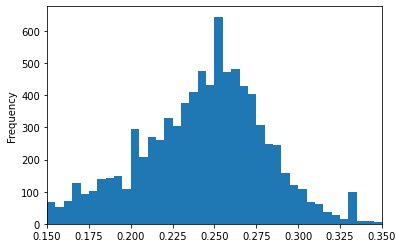

In [29]:
career_name['AVG'].plot.hist(xlim=[0.15, 0.35], bins=200, xlabel='average', ylabel='count')

Fitting the overall AVG with beta distribution. Getting the approximated $α, β$ 

In [30]:
from scipy.stats import beta
career_filter = career_name[career_name.AB > 500]
a0, b0, loc1, scale1 = beta.fit(career_filter['AVG'], floc=0, fscale=1)
print("alpha =", a0, "\n", "beta =", b0)

alpha = 79.6411398927643 
 beta = 228.55257615856598


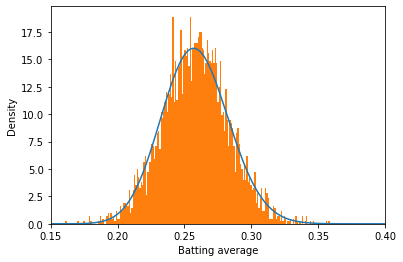

In [36]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a0, b0)
plt.plot(x, y)
plt.hist(career_filter['AVG'], bins=200, density=True)
plt.xlabel('Batting average')
plt.ylabel('Density')
plt.xlim(0.15, 0.4)
plt.show()

[likelihood_analytical]: MLE of betabinomial model


\[likelihood]: Consider the following hierarchical moddel 

$μ_i = β_0 + β_1*lnAB_i+ϵ\\ α_i = \frac{\mu_i}{\sigma} \\ \beta_i=\frac{1-\mu_i}{\sigma}\\ p_i∼Beta(α_i, \beta_i)$

and compute the MLE

In [43]:
from scipy.optimize import minimize
from scipy import special
from scipy import stats
x_i = np.array(career_filter['AVG'])
AB = np.array(career_filter['AB'])
logAB = np.array(np.log(career_filter['AB']))
H = np.array(career_filter['H'])
def likelihood(para):
  mu_i = para[0] + para[1] * logAB
  A_i = mu_i / para[2] - 1
  B_i = (1 - mu_i) / para[2] - 1 
  return -1 * sum(A_i * np.log(x_i) + B_i * np.log(1 - x_i) - special.gammaln(A_i + 1) - special.gammaln(B_i + 1) + special.gammaln(1/para[2]))
def likelihood_analytical(para):
  a = para[0]
  b = para[1]
  return -1 * sum((stats.betabinom.logpmf(H, AB, a, b)))

In [40]:
print(H)
print(stats.betabinom.pmf(H, AB, 79, 228))

[3771.  216.  772. ...  518.  199.  364.]
[0.00021914 0.00940388 0.00499551 ... 0.00063119 0.01683816 0.00670845]


Compute the parameters $\beta_0, \beta_1, \sigma$ of the hierarchical model

In [44]:
para0 = np.array([0.14, 0.015, 0.002])
res = minimize(likelihood, para0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res.x

Optimization terminated successfully.
         Current function value: -10452.862593
         Iterations: 95
         Function evaluations: 179


array([0.13297191, 0.01642835, 0.00234517])

Compute the parameters $\alpha, \beta$ of the betabinomial model

In [45]:
para0 = np.array([50, 290])
res = minimize(likelihood_analytical, para0, method='nelder-mead', options={'xatol': 1e-16, 'disp': True})
a1, b1 = res.x
res.x

Optimization terminated successfully.
         Current function value: 22947.704308
         Iterations: 118
         Function evaluations: 272


array([101.82219115, 289.62396127])

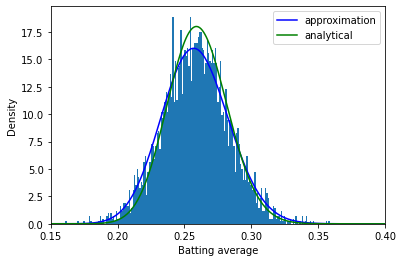

In [47]:
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a0, b0)
y_2 = beta.pdf(x, a1, b1)
plt.plot(x, y, color='blue', label='approximation')
plt.plot(x, y_2, color='green', label='analytical')
plt.hist(career_filter['AVG'], bins=200, density=True)
plt.xlabel('Batting average')
plt.ylabel('Density')
plt.xlim(0.15, 0.4)
plt.legend()
plt.show()

Consider the following model:

$μ_i = β_0 + β_1*lnAB_i+\beta_2*bats+ϵ\\ α_i = \frac{\mu_i}{\sigma} \\ \beta_i=\frac{1-\mu_i}{\sigma}\\ p_i∼Beta(α_i, \beta_i)$

and compute the MLE

In [55]:
career_filter = career_filter.assign(
    AVG_approxi=lambda df: (df.H + a0) / (df.AB + a0 + b0),
    AVG_analytical=lambda df: (df.H + a1) / (df.AB + a1 + b1))
career_filter.head()

,name,H,AB,AVG,AVG_analytical,AVG_approxi
0,Hank Aaron,3771.0,12364.0,0.304998,0.303621,0.303865
1,Tommie Aaron,216.0,944.0,0.228814,0.237990,0.236099
4,Ed Abbaticchio,772.0,3044.0,0.253614,0.254355,0.254055
5,Fred Abbott,107.0,513.0,0.208577,0.230884,0.227280
7,Jeff Abbott,157.0,596.0,0.263423,0.262113,0.261715


In [56]:
print(career_filter['AVG'].std(), career_filter['AVG_analytical'].std(), career_filter['AVG_approxi'].std())

0.02485229476400437 0.02005403473980877 0.02088416052274367


In [83]:
people = pd.read_csv("https://github.com/WellFan/bayesian_with_baseball/blob/main/baseballdatabank-2022.2/core/People.csv?raw=true")
master2 = (people[['playerID', 'nameFirst', 'nameLast', 'bats']]
           .assign(name=lambda df: df.nameFirst+' '+df.nameLast)
           .drop(columns=['nameFirst', 'nameLast']))
career_name2 = pd.merge(master2, career, how='inner', on='playerID')
career_name2 = (career_name2.drop(columns = 'playerID')
                .loc[~career_name2.bats.isnull()]
                .assign(bats = (career_name2.bats=='R').astype('int'))
                .loc[career_name2['AB']>500])
career_name2.head()

,bats,name,H,AB,AVG
0,1,Hank Aaron,3771.0,12364.0,0.304998
1,1,Tommie Aaron,216.0,944.0,0.228814
4,1,Ed Abbaticchio,772.0,3044.0,0.253614
5,1,Fred Abbott,107.0,513.0,0.208577
7,1,Jeff Abbott,157.0,596.0,0.263423


In [84]:
x_i = np.array(career_name2['AVG'])
logAB = np.array(np.log(career_name2['AB']))
bats = np.array(career_name2['bats'])
def likelihood2(para):
  mu_i = para[0] + para[1] * logAB + para[2] * bats
  A_i = mu_i / para[3] - 1
  B_i = (1 - mu_i) / para[3] - 1 
  return -1 * sum(A_i * np.log(x_i) + B_i * np.log(1 - x_i) - special.gammaln(A_i + 1) - special.gammaln(B_i + 1) + special.gammaln(1/para[3]))

In [85]:
para0 = np.array([0.14, 0.015, -0.01, 0.002])
res = minimize(likelihood2, para0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res.x

Optimization terminated successfully.
         Current function value: -10404.444435
         Iterations: 160
         Function evaluations: 294


array([ 0.1386039 ,  0.01620308, -0.00661675,  0.00228272])

Draw the posterior distribution of 

[r, l]: different handedness


[number]: different at bats

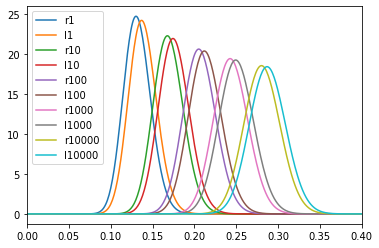

In [89]:
x = np.linspace(0, 1, 1000)
lr = [1,0] * 5
ab = [1, 1, 10, 10, 100, 100, 1000, 1000, 10000, 10000]
lr = np.array(lr)
ab = np.array(ab)
lnab = np.log(ab)
y = np.zeros((1000, 10))
y = pd.DataFrame(y)
for i in range(10):
  y[i] = beta.pdf(x, (res.x[0] + res.x[1] * lnab[i] + res.x[2] * lr[i]) / res.x[3], (1 - (res.x[0] + res.x[1] * lnab[i] + res.x[2] * lr[i])) / res.x[3])
for i in range(10):
  plt.plot(x, y[i], label=str("r" if lr[i] == 1 else "l") + str(10**(i // 2)))
plt.legend()
plt.xlim(0, 0.4)
plt.show()

Compute the credible interval of different kinds of batter

In [ ]:
var = [[3, 10], [30, 100], [300, 1000]]
def leftinterval(list):
  alpha_prior = (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 0) / res.x[3]
  beta_prior = (1 - (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 0)) / res.x[3]
  alpha_post = alpha_prior + list[0]
  beta_post = beta_prior + list[1] - list[0]
  return [beta.ppf(0.025, alpha_post, beta_post), beta.ppf(0.975, alpha_post, beta_post)]
def rightinterval(list):
  alpha_prior = (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 1) / res.x[3]
  beta_prior = (1 - (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 1)) / res.x[3]
  alpha_post = alpha_prior + list[0]
  beta_post = beta_prior + list[1] - list[0]
  return [beta.ppf(0.025, alpha_post, beta_post), beta.ppf(0.975, alpha_post, beta_post)]
print("left when 3/10", leftinterval(var[0]), "\nright when 3/10", rightinterval(var[0]))
print("left when 30/100", leftinterval(var[1]), "\nright when 30/100", rightinterval(var[1]))
print("left when 300/1000", leftinterval(var[2]), "\nright when 300/1000", rightinterval(var[2]))


left when 3/10 [0.14464514414479654, 0.21543521779249564] 
right when 3/10 [0.13871477769031015, 0.20848201419969337]
left when 30/100 [0.1948359550427392, 0.2657682508847931] 
right when 30/100 [0.1897651276126152, 0.2601028986794264]
left when 300/1000 [0.2618972675639635, 0.3085301700541036] 
right when 300/1000 [0.25993421721377297, 0.3064672691630672]


In [ ]:
import random
matrix = np.zeros((1000, 1000))
goods = random.sample(range(1000), 1000)
for i in range(1000):
  for j in range(1000):
    if j < goods[i]:
      matrix[i][j] = 1
    else:
      break
    j += 1
  i += 1
seller = pd.DataFrame(matrix)
seller.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
seller['seller_id'] = seller.index 
sellers = pd.melt(seller, id_vars=['seller_id'], var_name="good_id", value_name='exist')
sellers = sellers[sellers.exist == 1]
sellers = sellers.drop(columns=['exist'])
sellers.sort_values(['good_id'])
sellers.head()

,seller_id,good_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
ctr = pd.DataFrame(range(0, 1000), columns=['seller_id'])
ctr['ctr'] = list(np.random.beta(2, 98, 1000))
sellers = pd.merge(sellers, ctr, how='left', on='seller_id')
sellers.head()

,seller_id,good_id,ctr
0,0,0,0.008991
1,1,0,0.023312
2,2,0,0.019442
3,3,0,0.026465
4,4,0,0.007264


In [ ]:
sellers['ctr_good'] = sellers.apply(lambda row: np.random.beta(row.ctr*100, 100*(1-row.ctr)), axis = 1)
sellers['exposure'] = 100 * (np.random.exponential(1, len(sellers)) + 1)
sellers['click'] = sellers.apply(lambda row: np.random.binomial(row.exposure, row.ctr_good) + 1, axis = 1)
sellers.head()

,seller_id,good_id,ctr,ctr_good,exposure,click
0,0,0,0.008991,0.007086,190.647303,1
1,1,0,0.023312,0.027378,260.911447,11
2,2,0,0.019442,0.002958,312.422616,2
3,3,0,0.026465,0.011158,137.878799,2
4,4,0,0.007264,0.000413,178.603357,1


In [ ]:
sellers['average'] = sellers['click'] / sellers['exposure']
a0, b0, loc1, scale1 = beta.fit(sellers['average'], floc=0, fscale=1)
print("alpha_0 =", a0, "\n", "beta_0 =", b0)

alpha_0 = 1.497523814469557 
 beta_0 = 56.71289333077875


In [ ]:
H = sellers['click']
AB = sellers['exposure']
para0 = np.array([1, 45])
res = minimize(likelihood_analatic, para0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
a1, b1 = res.x
res.x

Optimization terminated successfully.
         Current function value: 1281515.600066
         Iterations: 80
         Function evaluations: 164


array([ 2.06472329, 79.0991135 ])

In [ ]:
sellers['average_eb'] = (sellers['click'] + a0) / (sellers['exposure'] + a0 + b0)
sellers['average_eba'] = (sellers['click'] + a1) / (sellers['exposure'] + a1 + b1)
sellers.head()

,seller_id,good_id,ctr,ctr_good,exposure,click,average,average_eb,average_eba
0,0,0,0.008991,0.007086,190.647303,1,0.005245,0.010036,0.011275
1,1,0,0.023312,0.027378,260.911447,11,0.042160,0.039162,0.038193
2,2,0,0.019442,0.002958,312.422616,2,0.006402,0.009437,0.010327
3,3,0,0.026465,0.011158,137.878799,2,0.014505,0.017836,0.018557
4,4,0,0.007264,0.000413,178.603357,1,0.005599,0.010546,0.011798


(array([5.24930e+04, 1.08911e+05, 5.23360e+04, 5.74140e+04, 3.87490e+04,
        3.84150e+04, 2.70640e+04, 2.53990e+04, 1.83740e+04, 1.65250e+04,
        1.23430e+04, 1.07240e+04, 8.04100e+03, 6.95700e+03, 5.26800e+03,
        4.55700e+03, 3.24000e+03, 2.86100e+03, 2.03400e+03, 1.81100e+03,
        1.31500e+03, 1.08600e+03, 7.94000e+02, 6.57000e+02, 5.03000e+02,
        3.76000e+02, 2.62000e+02, 2.58000e+02, 2.03000e+02, 1.17000e+02,
        9.40000e+01, 8.10000e+01, 5.80000e+01, 3.90000e+01, 3.20000e+01,
        3.20000e+01, 2.10000e+01, 1.20000e+01, 1.30000e+01, 7.00000e+00,
        4.00000e+00, 5.00000e+00, 6.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.00080837, 0.0057694 , 0.01073044, 0.01569148, 0.02065251,
        0.02561355, 0.03057459, 0.03553562, 0.04049666, 0.0454577 ,
        0.05041874, 0.05537977, 0.06034081, 0.06530185, 0.07026288,
        0.07522392, 0.08018496, 0.08514599, 0.09010703, 0.095068

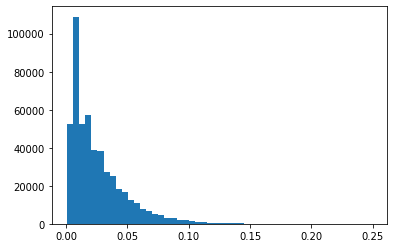

In [ ]:
plt.hist(sellers['average'], bins = 50)

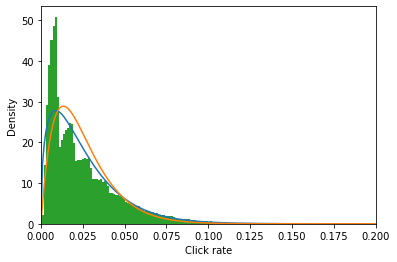

In [ ]:
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a0, b0)
y2 = beta.pdf(x, a1, b1)
plt.plot(x, y)
plt.plot(x, y2)
plt.xlim(0, 0.2)
plt.hist(sellers['average'], bins=200, density=True)
plt.xlabel('Click rate')
plt.ylabel('Density')
plt.show()

In [ ]:
mse = sum((sellers['average'] - sellers['ctr_good'])**2)
mse_eb = sum((sellers['average_eb'] - sellers['ctr_good'])**2)
mse_eba = sum((sellers['average_eba'] - sellers['ctr_good'])**2)
print('mse     =', mse, '\nmse_eb  =', mse_eb, '\nmse_eba =', mse_eba)

mse     = 76.0039372949509 
mse_eb  = 61.096011772641475 
mse_eba = 62.484164608732975


In [ ]:
selleronly = sellers.groupby(by='seller_id').agg({'ctr':'mean', 'exposure':'sum', 'click':'sum'})
selleronly.head()

,ctr,exposure,click
seller_id,,,
0,0.008991,68623.338294,972
1,0.023312,41727.629076,1137
2,0.019442,4177.075016,76
3,0.026465,11858.971910,382
4,0.007264,166205.986182,2027


In [ ]:
selleronly['average'] = selleronly['click'] / selleronly['exposure']
a0, b0, loc1, scale1 = beta.fit(selleronly['average'], floc=0, fscale=1)
print("alpha_0 =", a0, "\n", "beta_0 =", b0)

alpha_0 = 3.3306040650801907 
 beta_0 = 132.20309701172278


In [ ]:
H = selleronly['click']
AB = selleronly['exposure']
para0 = np.array([2, 101])
res = minimize(likelihood_analytical, para0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
a1, b1 = res.x
res.x

Optimization terminated successfully.
         Current function value: 8194.530566
         Iterations: 79
         Function evaluations: 176


array([  3.35725821, 133.19695741])

In [ ]:
selleronly['average_eb'] = (selleronly['click'] + a0) / (selleronly['exposure'] + a0 + b0)
selleronly['average_eba'] = (selleronly['click'] + a1) / (selleronly['exposure'] + a1 + b1)
selleronly.head()

,ctr,exposure,click,average,average_eb,average_eba
seller_id,,,,,,
0,0.008991,68623.338294,972,0.014164,0.014185,0.014185
1,0.023312,41727.629076,1137,0.027248,0.027239,0.027239
2,0.019442,4177.075016,76,0.018195,0.018395,0.018397
3,0.026465,11858.971910,382,0.032212,0.032126,0.032125
4,0.007264,166205.986182,2027,0.012196,0.012206,0.012206


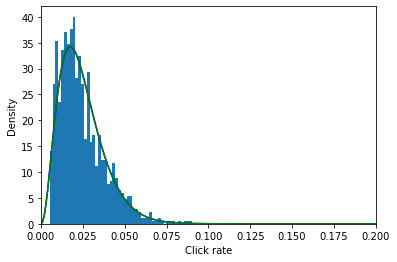

In [ ]:
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a0, b0)
y2 = beta.pdf(x, a1, b1)
plt.plot(x, y, color='blue')
plt.plot(x, y2, color='green')
plt.xlim(0, 0.2)
plt.hist(selleronly['average'], bins=50, density=True)
plt.xlabel('Click rate')
plt.ylabel('Density')
plt.show()

In [ ]:
mse = sum((selleronly['average'] - selleronly['ctr'])**2)
mse_eb = sum((selleronly['average_eb'] - selleronly['ctr'])**2)
mse_eba = sum((selleronly['average_eba'] - selleronly['ctr'])**2)
print('mse     =', mse, '\nmse_eb  =', mse_eb, '\nmse_eba =', mse_eba)

mse     = 0.027067092214363517 
mse_eb  = 0.026648075928023016 
mse_eba = 0.026647219937655755


In [ ]:
import stan
import arviz as az
!pip install nest_asyncio 
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> AB[N];
  int<lower=0> H[N];
}
parameters{
  real<lower=80, upper=120> alpha;
  real<lower=210, upper=290> beta;
}
model{
  H~beta_binomial(AB, alpha, beta);
}
'''
stan_data = {'N':4245, 'AB':list(career_name2['AB'].astype(int)), 'H': list(career_name2['H_x'].astype(int))}
posterior = stan.build(text2, data=stan_data)
fitt = posterior.sample(num_chains=1, num_samples=1000)


Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.001083 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.83 seconds.
  Adjust your expectations accordingly!


In [ ]:
dff = fitt.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta
draws,,,,,,,,,
0,-6.950871e+06,0.978109,0.065665,4.0,27.0,0.0,6.950872e+06,98.416362,279.693659
1,-6.950871e+06,0.976280,0.065665,4.0,17.0,0.0,6.950872e+06,98.195529,278.926547
2,-6.950872e+06,0.813488,0.065665,5.0,35.0,0.0,6.950872e+06,99.345200,282.997667
3,-6.950871e+06,1.000000,0.065665,1.0,1.0,0.0,6.950872e+06,99.348467,282.828273
4,-6.950872e+06,0.984622,0.065665,5.0,47.0,0.0,6.950872e+06,98.340950,279.913308


In [ ]:
print("beta =", dff.beta.mean(), 'alpha =', dff.alpha.mean())
az.summary(fitt)

beta = 284.1373101173045 alpha = 99.95746810346404


Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,99.957,1.467,97.008,102.215,0.163,0.116,89.0,130.0,NaN
beta,284.137,4.135,276.013,289.885,0.458,0.325,84.0,116.0,NaN


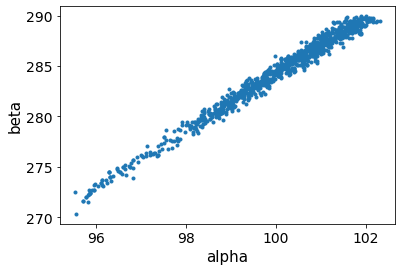

In [ ]:
az.plot_pair(fitt)

In [ ]:
text='''
data{
  int<lower=0> N;
  int<lower=0> AB[N];
  real logAB[N];
  int<lower=0> H[N];
  int<lower=0, upper=1> bat[N];
}
parameters{
  real beta0;
  real beta1;
  real beta2;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] mu_i;
  vector[N] alpha_i;
  vector[N] beta_i;
  mu_i = beta0 + to_vector(logAB)*beta1  + to_vector(bat)*beta2;
  alpha_i = mu_i/sigma;
  beta_i = (1-mu_i)/sigma;
}
model{
  beta0~normal(0.138, 0.001);
  beta1~normal(0.0162, 0.0001);
  beta2~normal(-0.0066, 0.0001);
  sigma~normal(0.0022, 0.0001);
  H~beta_binomial(AB, alpha_i, beta_i);
}
'''

In [ ]:
stan_data = {'N':4245, 'AB':list(career_name2['AB'].astype(int)), 'logAB': list(logAB), 'H': list(career_name2['H_x'].astype(int)), 'bat': list(bats)}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=1000)

In [ ]:
az.summary(fit)

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.138,0.001,0.137,0.139,0.000,0.000,501.0,358.0,NaN
beta1,0.016,0.000,0.016,0.016,0.000,0.000,495.0,442.0,NaN
beta2,-0.007,0.000,-0.007,-0.006,0.000,0.000,839.0,591.0,NaN
sigma,0.002,0.000,0.002,0.002,0.000,0.000,86.0,89.0,NaN
mu_i[0],0.285,0.000,0.284,0.285,0.000,0.000,827.0,643.0,NaN
...,...,...,...,...,...,...,...,...,...
beta_i[4240],414.097,11.660,393.433,438.278,1.300,0.929,86.0,95.0,NaN
beta_i[4241],429.148,12.082,407.815,454.308,1.348,0.963,86.0,89.0,NaN
beta_i[4242],420.529,11.841,399.579,445.128,1.320,0.944,86.0,89.0,NaN
beta_i[4243],431.299,12.142,409.870,456.598,1.355,0.968,86.0,89.0,NaN


In [ ]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta0,beta1,beta2,...,beta_i.4236,beta_i.4237,beta_i.4238,beta_i.4239,beta_i.4240,beta_i.4241,beta_i.4242,beta_i.4243,beta_i.4244,beta_i.4245
draws,,,,,,,,,,,,,,,,,,,,,
0,-6.950164e+06,0.998689,0.012613,5.0,63.0,0.0,6.950166e+06,0.138026,0.016321,-0.006675,...,394.002591,389.814227,404.434357,387.834378,399.954812,390.081664,404.346958,396.177879,406.384854,398.655386
1,-6.950167e+06,0.981406,0.012613,3.0,15.0,0.0,6.950168e+06,0.138190,0.016210,-0.006852,...,394.521622,390.361362,404.883391,388.394798,400.315390,390.627005,404.796578,396.682314,406.820800,399.024684
2,-6.950164e+06,1.000000,0.012613,3.0,7.0,0.0,6.950168e+06,0.137944,0.016206,-0.006482,...,394.381087,390.222831,404.737865,388.257214,400.368875,390.488346,404.651093,396.540738,406.674340,399.078791
3,-6.950164e+06,1.000000,0.012613,3.0,7.0,0.0,6.950165e+06,0.137989,0.016325,-0.006624,...,394.056290,389.866058,404.492705,387.885327,400.039348,390.133615,404.405267,396.232547,406.444071,398.739343
4,-6.950163e+06,0.877171,0.012613,1.0,3.0,0.0,6.950165e+06,0.137974,0.016235,-0.006653,...,394.427301,390.260627,404.805042,388.291032,400.342067,390.526680,404.718095,396.591323,406.745437,399.049371


In [ ]:
beta0_stan = df.beta0.mean()
beta1_stan = df.beta1.mean()
beta2_stan = df.beta2.mean()
sigma_stan = df.sigma.mean()
career_name2 = career_name2.assign(average_stan=lambda x: ((beta0_stan+beta1_stan*logAB+beta2_stan*bats)+sigma_stan*x['H_x'])/(1+sigma_stan*x['AB']))

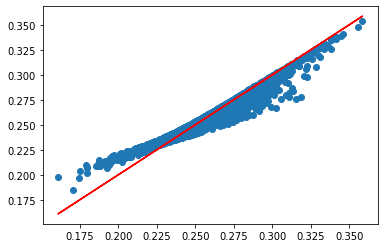

In [ ]:
plt.scatter(career_name2['average'], career_name2['average_stan'])
plt.plot(career_name2['average'], career_name2['average'], color='red')